# Traitement naturel du language
## Création d'un RNN pour la classification de phrases en six émotions

----------------------

In [1]:
from RNN import *
from data_processing import *

#### Chargement des données

In [2]:
text, emotion = load_file("./dataset/train.txt")

print(text[2])
print(tokenizer(text[2]))
print(emotion[2])

im grabbing a minute to post i feel greedy wrong
['im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']
anger


#### Création de l'ensemble de mots 
1. Lister tous les tokens

In [3]:
lst = list(yield_tokens(text))
print(lst[:50])
print(lst[-50:])

['i', 'didnt', 'feel', 'humiliated', 'i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', 'i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still']
['i', 'feel', 'pathetic', 'that', 'i', 'am', 'still', 'waiting', 'tables', 'and', 'subbing', 'with', 'a', 'teaching', 'degree', 'i', 'feel', 'strong', 'and', 'good', 'overall', 'i', 'feel', 'like', 'this', 'was', 'such', 'a', 'rude', 'comment', 'and', 'im', 'glad', 'that', 't', 'i', 'know', 'a', 'lot', 'but', 'i', 'feel', 'so', 'stupid', 'because', 'i', 'can', 'not', 'portray', 'it']


2. Associer à chaque mot une valeur unique (entier positif) **pas de doublon**

In [4]:
vocab = build_vocab_from_iterator(lst, specials=["<pad>", "<unk>"])
print(len(vocab))
print(vocab["i"])
print(vocab["didnt"])
print(vocab["feel"])

15214
2
3
4


#### Faire pareil avec les émotions, qui représentent les classes

In [5]:
classes = build_vocab_from_iterator(yield_tokens(emotion))
print(len(classes))
print(classes["anger"])

6
1


#### Coder une phrase 
1. Représenter une phrase comme une suite de valeurs

In [6]:
print(text[1])
codage_entier_phrase = [vocab[word] for word in tokenizer(text[1])]
print(codage_entier_phrase)

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
[2, 6, 7, 8, 9, 10, 11, 12, 10, 13, 14, 15, 8, 16, 17, 18, 19, 20, 21, 22, 23]


2. Représenter chaque phrase comme un tensor d'entiers **seulement à partir de cette étape, on utiliser la librairie pytorch**

In [7]:
tensor_entier = torch.tensor(codage_entier_phrase)
print(tensor_entier)

tensor([ 2,  6,  7,  8,  9, 10, 11, 12, 10, 13, 14, 15,  8, 16, 17, 18, 19, 20,
        21, 22, 23])


3. Représenter chaque phrase comme un tensor one hot **attention, il peut être difficile de charger en mémoire l'ensemble du dataset sous la forme on-hot, privilégier si besoin la génération one-hot par batch, en utilisant un Dataloader**

In [8]:
tensor_one_hot = torch.nn.functional.one_hot(tensor_entier, num_classes=len(vocab))
print(tensor_one_hot)

tensor([[0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


4. Ensuite : 
- Finaliser le codage : 
    - rogner ou compléter les phrase (*pad*) : longeur identique en entrée du réseau quelque soit la phrase 
    - optimiser : *unk* pour les mots sous représentés 
    - préparer le réseau 
    - entrainer le réseau sur la classification des émotions 
    - optimiser, analyser les résultats 
    - entrainer le réseau de façon autosupervisée : prédiction du mots suivant à partir de mots précédents par exemple 
    - analyser l'embeding

#### Rogner ou compléter les phrases

(array([2641., 3795., 3968., 2306., 1499.,  963.,  453.,  251.,  106.,
          18.]),
 array([ 2. ,  8.4, 14.8, 21.2, 27.6, 34. , 40.4, 46.8, 53.2, 59.6, 66. ]),
 <BarContainer object of 10 artists>)

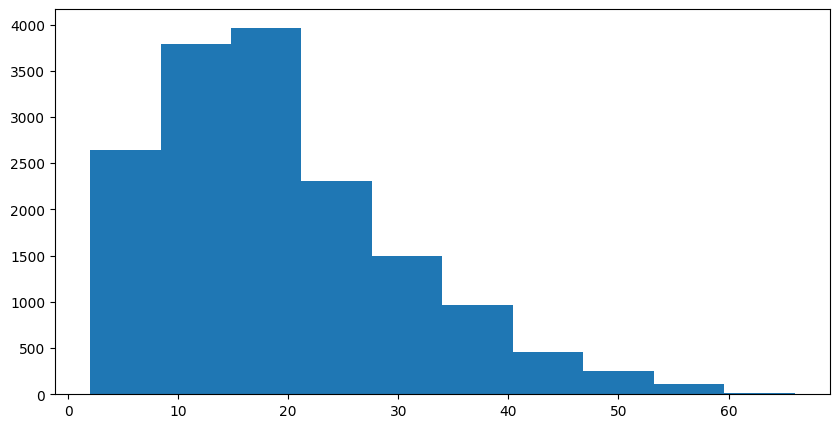

In [9]:
import matplotlib.pyplot as plt

"""sentences_lenght = {}
for sentence in text:
    size = len(sentence)
    sentences_lenght[size] = sentences_lenght.get(size, 0) + 1"""

sentences_lenght = [len(sentence.split(" ")) for sentence in text]

plt.figure(figsize=(10,5))
plt.hist(sentences_lenght)

Au vue de la distribution de la taille des phrases, on peut considérer que ne garder que les phrases de taille inférieure à 20 sera déjà un bon départ pour le réseau

In [10]:
size_threshold = 20
lst = list(yield_tokens(text, threshold=size_threshold))
print(lst[:50])
print(len(lst))

['i', 'didnt', 'feel', 'humiliated', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'im', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will']
197880


#### Unknown pour les mots sous-représentés

In [11]:
appearance_threshold = 3
lst_with_unk = yield_tokens_with_unknown(lst, threshold=appearance_threshold)
lst_with_unk

['i',
 'didnt',
 'feel',
 'humiliated',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'im',
 '<unk>',
 'a',
 'minute',
 'to',
 'post',
 'i',
 'feel',
 'greedy',
 'wrong',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'i',
 'am',
 'ever',
 'feeling',
 'nostalgic',
 'about',
 'the',
 '<unk>',
 'i',
 'will',
 'know',
 'that',
 'it',
 'is',
 'still',
 'on',
 'the',
 '<unk>',
 '<pad>',
 '<pad>',
 'i',
 'am',
 'feeling',
 'grouchy',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'ive',
 'been',
 'feeling',
 'a',
 'little',
 'burdened',
 'lately',
 'wasnt',
 'sure',
 'why',
 'that',
 'was',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 'i',
 'feel',
 'as',
 'confused',
 'about',


#### Préparer le réseau

1. Batch des données de train (DataLoader)

In [2]:
# parameters for filtering the vocabulary
size_threshold = 20
appearance_threshold = 3

In [3]:
# load text and emotion data for training, validation and test sets
text_train, emotion_train = load_file("./dataset/train.txt")
text_validation , emotion_validation = load_file("./dataset/val.txt")
text_test, emotion_test = load_file("./dataset/test.txt")

# build vocabulary for each set
lst_train_with_unk = list(yield_tokens_with_unknown(list(yield_tokens(text_train, threshold=size_threshold)), 
                                                    threshold=appearance_threshold))
vocab_train = build_vocab_from_iterator(lst_train_with_unk, specials=["<pad>", "<unk>"])

lst_val = list(yield_tokens(text_validation, threshold=size_threshold)) # we do not add <unk> in the validation and test sets, we just replace unknown words (not in the train set) by <unk>
lst_test = list(yield_tokens(text_test, threshold=size_threshold))

# convert to OneHotEncoder dataset
nb_train_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_train)
nb_validation_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_validation)
nb_test_sentences = sum(len(sentence.split(" "))<=size_threshold for sentence in text_test)

print(f"Number of training sentences: {nb_train_sentences}")
print(f"Number of validation sentences: {nb_validation_sentences}")
print(f"Number of test sentences: {nb_test_sentences}")

Number of training sentences: 9894
Number of validation sentences: 1262
Number of test sentences: 1230


In [4]:
# keep only emotion from sentences of length <= size_threshold
emotion_train = [emotion_train[i] for i in range(len(text_train)) if len(text_train[i].split(" "))<=size_threshold]
emotion_validation = [emotion_validation[i] for i in range(len(text_validation)) if len(text_validation[i].split(" "))<=size_threshold]
emotion_test = [emotion_test[i] for i in range(len(text_test)) if len(text_test[i].split(" "))<=size_threshold]

lst_train_emotion = list(yield_tokens(emotion_train))
emotion_classes = build_vocab_from_iterator(lst_train_emotion) # we build the emotion classes only with the training set

lst_val_emotion = list(yield_tokens(emotion_validation))
lst_test_emotion = list(yield_tokens(emotion_test))

In [5]:
train_dataset = OneHotEncoder(tokenized_text=lst_train_with_unk, 
                              vocab=vocab_train, 
                              nb_sentences=nb_train_sentences, 
                              tokenized_emotion=lst_train_emotion, 
                              emotion_classes=emotion_classes)
validation_dataset = OneHotEncoder(tokenized_text=lst_val, 
                                    vocab=vocab_train, 
                                    nb_sentences=nb_validation_sentences, 
                                    tokenized_emotion=lst_val_emotion, 
                                    emotion_classes=emotion_classes)
test_dataset = OneHotEncoder(tokenized_text=lst_test, 
                              vocab=vocab_train, 
                              nb_sentences=nb_test_sentences, 
                              tokenized_emotion=lst_test_emotion, 
                              emotion_classes=emotion_classes)

In [6]:
print("First sentence of the training set (text):")
print(text_train[0])
print("Associated emotion:", emotion_train[0])
print("First sentence of the training set (one-hot encoded):")
print(train_dataset[0])

First sentence of the training set (text):
i didnt feel humiliated
Associated emotion: sadness
First sentence of the training set (one-hot encoded):
(tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]]), tensor([1., 0., 0., 0., 0., 0.]))


Le réseau de neurone prend en entrée de façon récurrente un vecteur : $(batch_{size},vocab_{size})$. Soit par exemple pour un $batch_{size} = 10$, $sentence_{size} = 20$ :
 les dix premiers mots, les dix seconds mots, ..., les dix vingtièmes mots

2. Création du modèle

In [7]:
# hyperparameters definition
emb_size = 64 # arbitrary choice
hidden_size = 128 # arbitrary choice
rnn_layers = 1

eta = 1e-3
n_epochs=50

In [8]:
device = "xpu" if torch.xpu.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = RNN(input_size=len(vocab_train),hidden_size=hidden_size,emb_size=emb_size,output_size=len(emotion_classes),num_layers=rnn_layers).to(device)
print(model)

Using xpu device
RNN(
  (i2e): Linear(in_features=2098, out_features=64, bias=True)
  (softmax): LogSoftmax(dim=1)
  (rnn): RNNcell(
    (tanh): Tanh()
    (i2h): Linear(in_features=64, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (h2o): Linear(in_features=128, out_features=6, bias=True)
)


In [9]:
loss_func = torch.nn.CrossEntropyLoss(reduction='mean')
optim = torch.optim.SGD(model.parameters(), lr=eta) # trouver la méthode pour faire un équilibrage des classes dans un second temps

3. Test du modèle (sans/avec récurrence, phrase unique/batch)

In [10]:
# Test with no recurrence (single word to predict the emotion, batch_size=1)
X, y = next(iter(train_dataset))
X, y = X.to(device), y.to(device)
pred = model(X.unsqueeze(0), recurrence=False)
print(pred, y)

tensor([[-1.8755, -1.7016, -1.7049, -1.9087, -1.8619, -1.7210]],
       device='xpu:0', grad_fn=<LogSoftmaxBackward0>) tensor([1., 0., 0., 0., 0., 0.], device='xpu:0')


In [11]:
# Test of the network, calling it with recurrence (batch_size=1)
X, y = next(iter(train_dataset))
pred = model(X.unsqueeze(0).to(device), recurrence=True)
print(pred, y)

tensor([[-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206]],
       device='xpu:0', grad_fn=<LogSoftmaxBackward0>) tensor([1., 0., 0., 0., 0., 0.])


In [12]:
# Test of the network, calling it with recurrence (batch_size>1)
batch_size = 10

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

X, y = next(iter(train_loader))
X, y = X.to(device), y.to(device)  # Move both X and y to the device
pred = model(X, recurrence=True)
print(pred, y)

tensor([[-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206],
        [-1.8754, -1.7023, -1.7048, -1.9083, -1.8621, -1.7206]],
       device='xpu:0', grad_fn=<LogSoftmaxBackward0>) tensor([[0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0.],

#### Entrainer le réseau sur la classification des émotions

In [ ]:
batch_size = 10

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(validation_dataset, batch_size=1, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
best_score = 0
counter = 0
train_losses, val_losses = [], [] # to store the losses for plotting later
writer = torch.utils.tensorboard.SummaryWriter()
for t in range(n_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_func, optim, device, recurrence=True)
    val_accuracy, val_loss = test(validation_loader, model, loss_func, device, recurrence=True)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    stop, best_score, counter = early_stopping(best_score, val_accuracy, threshold=0.001, patience=5, counter=counter)
    if stop:
        break

    writer.add_scalar('Loss/train', train_loss, t)
    writer.add_scalar('Loss/validation', val_loss, t)
    writer.add_scalar('Accuracy/validation', val_accuracy, t)

print(f"Best validation accuracy reached: {best_score*100:>0.1f}%, after {t+1} epochs")

# visualize the training curves with tensorboard
writer.flush()
writer.close()
# tensorboard --logdir=runs (launch this command in the terminal)

# visualize the training and validation loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# add computation of confusion matrix (to be done)

In [ ]:
# hyperparameters tuning (to be done)

#### Optimiser, analyser les résultats

In [ ]:
# limiter l'effet du déséquilibre des classes (loss adaptée)
# changer le threshold de filtrage des mots rares

#### Approfondissement

In [ ]:
# matrice d'embedding : observer la représentation des mots dans l'espace des embeddings

In [ ]:
# apprentissage auto-supervisé des embeddings (word2vec, GloVe, FastText)